<a href="https://colab.research.google.com/github/RuchitShivani/3D-Mesh-Normalization-Quantization-and-Reconstruction/blob/main/Relevant%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install trimesh open3d numpy matplotlib

import trimesh, open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os, json


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


Task 1: Load and Inspect the mesh


In [2]:
from google.colab import files

uploaded = files.upload()

mesh_path = list(uploaded.keys())[0]
mesh = trimesh.load(mesh_path, force='mesh', process=False)
mesh


Saving branch.obj to branch.obj
Saving cylinder.obj to cylinder.obj
Saving explosive.obj to explosive.obj
Saving fence.obj to fence.obj
Saving girl.obj to girl.obj
Saving person.obj to person.obj
Saving table.obj to table.obj
Saving talwar.obj to talwar.obj


<trimesh.Trimesh(vertices.shape=(2767, 3), faces.shape=(1960, 3))>

Inspect Vertices & Basic Statistics

In [3]:
vertices = mesh.vertices
faces = mesh.faces

print(f"Number of vertices: {len(vertices)}")

stats = {
    "min": vertices.min(axis=0),
    "max": vertices.max(axis=0),
    "mean": vertices.mean(axis=0),
    "std": vertices.std(axis=0)
}

for k, v in stats.items():
    print(f"{k}: {v}")


Number of vertices: 2767
min: [-0.851562  0.       -0.464844]
max: [0.849609 1.900391 0.462891]
mean: [0.0754427  1.0873903  0.12196689]
std: [0.3433802  0.45699113 0.20006684]


Task 2: Normalization Methods

Min–Max Normalization

In [4]:
def normalize_minmax(v):
    vmin, vmax = v.min(axis=0), v.max(axis=0)
    scale = vmax - vmin
    scale[scale == 0] = 1
    v_norm = (v - vmin) / scale
    return v_norm, (vmin, scale)

v_minmax, (vmin, scale) = normalize_minmax(vertices)
print("Min–Max normalized range per axis:")
print(v_minmax.min(axis=0), v_minmax.max(axis=0))


Min–Max normalized range per axis:
[0. 0. 0.] [1. 1. 1.]


Unit Sphere Normalization

In [5]:
def normalize_unit_sphere(v):
    center = v.mean(axis=0)
    v_c = v - center
    radius = np.linalg.norm(v_c, axis=1).max()
    if radius == 0: radius = 1
    v_norm = v_c / radius
    return v_norm, (center, radius)

v_unit, (center, radius) = normalize_unit_sphere(vertices)
print("Unit Sphere normalized - mean:", v_unit.mean(axis=0))


Unit Sphere normalized - mean: [ 2.99483363e-16 -4.17928552e-15  5.45361451e-16]


Quantization

In [6]:
BINS = 1024

def quantize(v_norm, method='minmax'):
    if method == 'minmax':
        q = np.round(v_norm * (BINS-1)).astype(int)
    else:  # unit sphere maps [-1,1] → [0,1]
        q = np.round(((v_norm + 1)/2) * (BINS-1)).astype(int)
    return q

q_minmax = quantize(v_minmax, 'minmax')
q_unit = quantize(v_unit, 'unit')


Save the outputa to view in Spin3D software

In [7]:
def save_mesh(vertices, faces, path):
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    o3d.io.write_triangle_mesh(path, mesh)

save_mesh(v_minmax, faces, "normalized_minmax.ply")
save_mesh(v_unit, faces, "normalized_unit.ply")
save_mesh(q_minmax / (BINS-1), faces, "quantized_minmax.ply")
save_mesh((q_unit/(BINS-1))*2-1, faces, "quantized_unit.ply")


Task 3: Dequantize + Denormalize(Reconstruction & Error)

In [8]:
def dequantize(q, method='minmax'):
    if method == 'minmax':
        return q / (BINS-1)
    else:
        return (q/(BINS-1))*2 - 1

def denormalize_minmax(vn, vmin, scale):
    return vn * scale + vmin

def denormalize_unit(vn, center, radius):
    return vn * radius + center

v_minmax_rec = denormalize_minmax(dequantize(q_minmax,'minmax'), vmin, scale)
v_unit_rec   = denormalize_unit(dequantize(q_unit,'unit'), center, radius)


Compute Errors + Plot


Min–Max reconstruction:
MSE: 1.9049865752934312e-07 MAE: 0.0003633901429629063
MSE per axis: [2.29524828e-07 2.73551803e-07 6.84193420e-08]


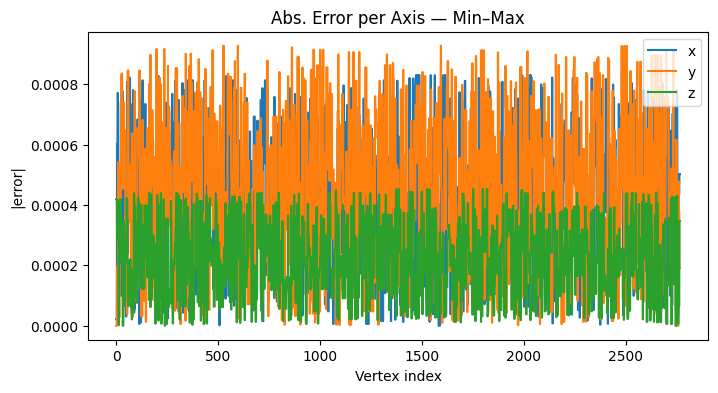


Unit Sphere reconstruction:
MSE: 5.801006190760608e-07 MAE: 0.0006584236244302268
MSE per axis: [5.48394590e-07 5.81280235e-07 6.10627032e-07]


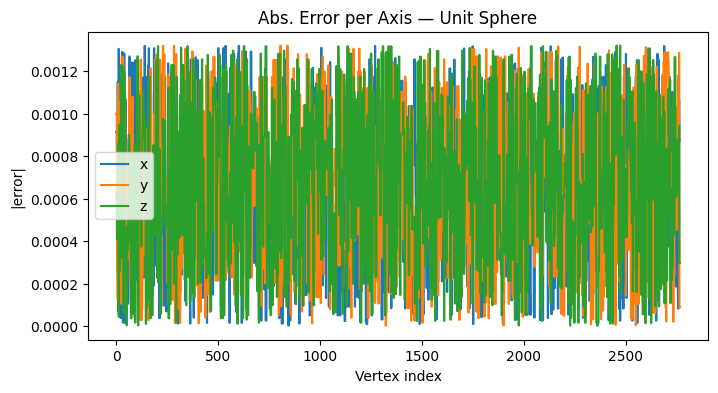

In [9]:
def mse_mae(original, reconstructed):
    diff = original - reconstructed
    mse_axis = (diff**2).mean(axis=0)
    mae_axis = np.abs(diff).mean(axis=0)
    mse = (diff**2).mean()
    mae = np.abs(diff).mean()
    return mse, mae, mse_axis, mae_axis, diff

for name, v_rec in [("Min–Max", v_minmax_rec), ("Unit Sphere", v_unit_rec)]:
    mse, mae, mse_axis, mae_axis, diff = mse_mae(vertices, v_rec)
    print(f"\n{name} reconstruction:")
    print("MSE:", mse, "MAE:", mae)
    print("MSE per axis:", mse_axis)

    plt.figure(figsize=(8,4))
    plt.plot(np.abs(diff[:,0]), label='x')
    plt.plot(np.abs(diff[:,1]), label='y')
    plt.plot(np.abs(diff[:,2]), label='z')
    plt.legend(); plt.title(f"Abs. Error per Axis — {name}")
    plt.xlabel("Vertex index"); plt.ylabel("|error|")
    plt.show()
